## Q1


In [12]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def log_joint_posterior(theta, tau, data, theta0, tau0, alpha, lam):
    """
    Computes the log unnormalized joint posterior:
    log p(theta, tau | x) = log p(x | theta, tau) + log p(theta) + log p(tau)
    
    Args:
      theta : proposed mean
      tau   : proposed precision
      data  : observed data (array)
      theta0: prior mean for theta
      tau0  : prior precision for theta
      alpha : shape of Gamma prior for tau
      lam   : rate of Gamma prior for tau
    
    Returns:
      log posterior value
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)

    # Log-likelihood (Normal with precision tau)
    log_likelihood = (n/2) * np.log(tau) - 0.5 * tau * sum_sq

    # Log-prior for theta (Normal with precision tau0)
    log_prior_theta = -0.5 * tau0 * (theta - theta0)**2

    # Log-prior for tau (Gamma with shape alpha, rate lambda)
    log_prior_tau = (alpha - 1) * np.log(tau) - lam * tau

    return log_likelihood + log_prior_theta + log_prior_tau

def metropolis_within_gibbs(data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using **Exponential(2)** as a proposal for tau.
    
    Args:
      data     : 1D array of observed data
      theta0   : prior mean for theta
      tau0     : prior precision for theta
      alpha    : shape for Gamma prior on tau
      lam      : rate for Gamma prior on tau
      n_iter   : number of iterations
      burn_in  : number of samples to discard
      prop_sd_theta : proposal standard deviation for theta
    
    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    
    # Storage
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    tau_current = np.random.gamma(shape=alpha, scale=1/lam)  
    theta_current = np.random.normal(theta0, 1 / np.sqrt(tau0))  

    for t in range(n_iter):
        # -------------------------------------------------
        # Step 1: Metropolis update for theta
        # -------------------------------------------------
        theta_proposed = np.random.normal(theta_current, prop_sd_theta/2)

        log_p_current_theta = log_joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        log_p_proposed_theta = log_joint_posterior(theta_proposed, tau_current, data, theta0, tau0, alpha, lam)
        
        acceptance_ratio_theta = np.exp(log_p_proposed_theta - log_p_current_theta)
        
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed  # Accept

        # -------------------------------------------------
        # Step 2: Metropolis update for tau (Using **Exponential(2)** Proposal)
        # -------------------------------------------------
        tau_proposed = np.random.exponential(scale=2)  # **EXACTLY AS YOU WANT IT**
        
        log_p_current_tau = log_joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        log_p_proposed_tau = log_joint_posterior(theta_current, tau_proposed, data, theta0, tau0, alpha, lam)

        # Compute Metropolis-Hastings ratio (correcting for asymmetric Exponential proposal)
        proposal_ratio = stats.expon(scale=2).pdf(tau_current) / stats.expon(scale=2).pdf(tau_proposed)
        acceptance_ratio_tau = np.exp(log_p_proposed_tau - log_p_current_tau) * proposal_ratio
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed  # Accept

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

# ---------------------------------------------
# Run the Metropolis-within-Gibbs Sampler
# ---------------------------------------------
np.random.seed(42)  # For reproducibility

# Simulated data
n = 30
true_theta = 5
true_tau = 1  # Precision
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=n)

# Prior parameters
theta0 = 4      # Prior mean for theta
tau0 = 2        # Prior precision for theta
alpha = 2       # Shape of Gamma prior for tau
lam = 1         # Rate of Gamma prior for tau

# MCMC settings
n_iter = 5000
burn_in = 1000
prop_sd_theta = 3  # Larger step for better mixing

theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta
)

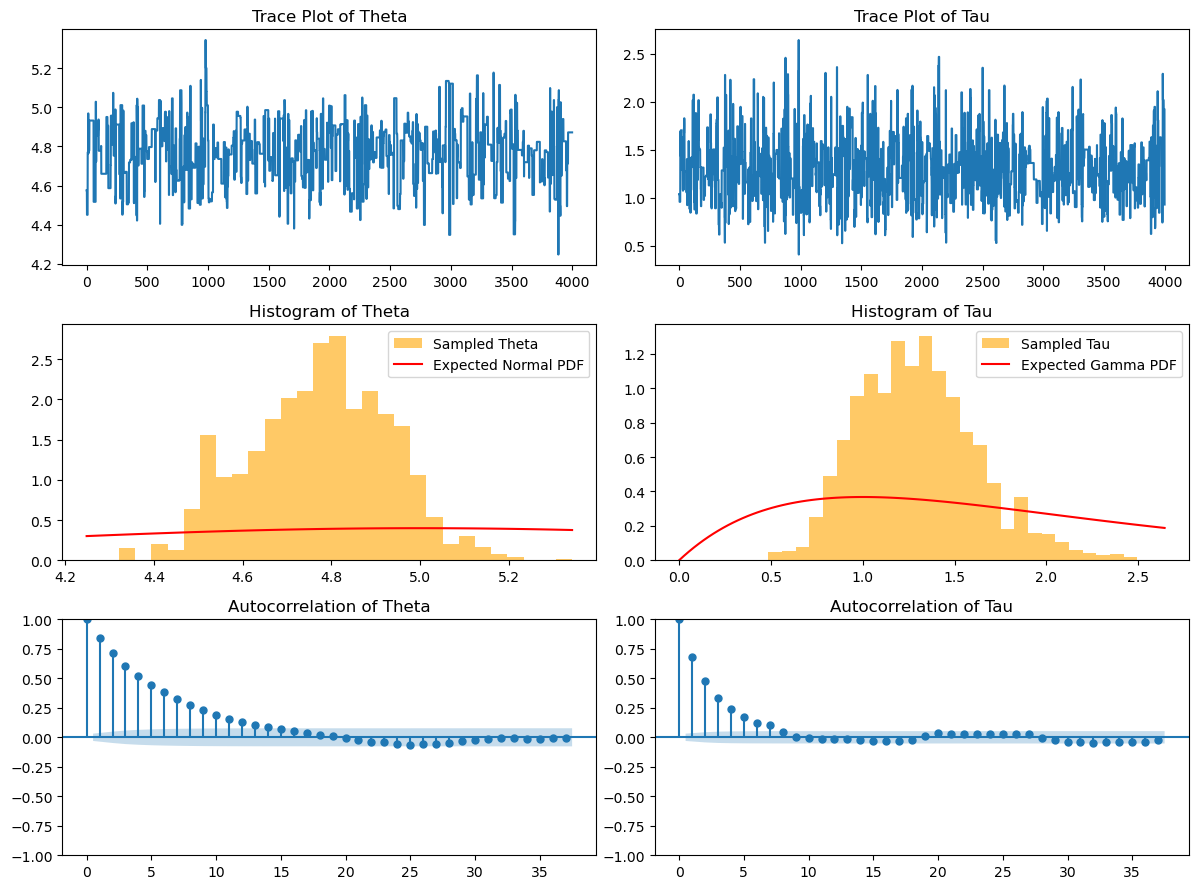

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

# Trace plots
axes[0, 0].plot(theta_samples)
axes[0, 0].set_title("Trace Plot of Theta")
axes[0, 1].plot(tau_samples)
axes[0, 1].set_title("Trace Plot of Tau")

# Histograms with priors
x_range = np.linspace(min(theta_samples), max(theta_samples), 100)
theta_prior_pdf = stats.norm.pdf(x_range, loc=true_theta, scale=true_tau)
axes[1, 0].hist(theta_samples, bins=30, density=True, alpha=0.6, color="orange", label="Sampled Theta")
axes[1, 0].plot(x_range, theta_prior_pdf, "r", label="Expected Normal PDF")
axes[1, 0].set_title("Histogram of Theta")
axes[1, 0].legend()

tau_range = np.linspace(0, max(tau_samples), 100)
tau_prior_pdf = stats.gamma.pdf(tau_range, a=alpha, scale=1/lam)
axes[1, 1].hist(tau_samples, bins=30, density=True, alpha=0.6, color="orange", label="Sampled Tau")
axes[1, 1].plot(tau_range, tau_prior_pdf, "r", label="Expected Gamma PDF")
axes[1, 1].set_title("Histogram of Tau")
axes[1, 1].legend()

# Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(theta_samples, ax=axes[2, 0])
axes[2, 0].set_title("Autocorrelation of Theta")
plot_acf(tau_samples, ax=axes[2, 1])
axes[2, 1].set_title("Autocorrelation of Tau")

plt.tight_layout()
plt.show()

#### Discussion

Comparing to pure Gibbs sampler, we don't know the full conditional, and it's slower for the convergence speed; MH-Gibbs sampler's convergence speed might be influenced by the proposal distribution(high rejection rate or high accepting rate causes slow convergence). More essentially, the histogram of theta and Tau are showing that the true value is not consistly being the center of distribution; I have tried to fix it by adjusting the proposal distribution such that it has a higher/lower rejection rate, however, the issue still exist. Moreover, the Autocorrelation of Theta dropping rate is always slower than Tau, so, I have changed the proposal scale with 05 * original scale. 

## Q2

In [16]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def log_joint_posterior(theta, tau, data, theta0, b_theta, alpha, lam):
    """
    Computes the log unnormalized joint posterior:
    log p(theta, tau | x) = log p(x | theta, tau) + log p(theta) + log p(tau)
    
    Args:
      theta : proposed mean
      tau   : proposed precision
      data  : observed data (array)
      theta0: location parameter for Laplace prior on theta
      b_theta : scale parameter for Laplace prior on theta
      alpha : shape of Gamma prior for tau
      lam   : rate of Gamma prior for tau
    
    Returns:
      log posterior value
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)

    # Log-likelihood (Normal with precision tau)
    log_likelihood = (n/2) * np.log(tau) - 0.5 * tau * sum_sq

    # Log-prior for theta (Laplace)
    log_prior_theta = -np.abs(theta - theta0) / b_theta

    # Log-prior for tau (Gamma with shape alpha, rate lambda)
    log_prior_tau = (alpha - 1) * np.log(tau) - lam * tau

    return log_likelihood + log_prior_theta + log_prior_tau

def metropolis_within_gibbs(data, theta0, b_theta, alpha, lam, n_iter, burn_in, prop_sd_theta, s_tau):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using truncated normal as the proposal for tau and Laplace prior for theta.
    
    Args:
      data     : 1D array of observed data
      theta0   : location parameter for Laplace prior on theta
      b_theta  : scale parameter for Laplace prior on theta
      alpha    : shape for Gamma prior on tau
      lam      : rate for Gamma prior on tau
      n_iter   : number of iterations
      burn_in  : number of samples to discard
      prop_sd_theta : proposal standard deviation for theta
      s_tau    : scale parameter for truncated normal proposal for tau
    
    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    
    # Storage
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    tau_current = np.random.gamma(shape=alpha, scale=1/lam)  
    theta_current = np.random.laplace(loc=theta0, scale=b_theta)  # Laplace prior initialization

    for t in range(n_iter):
        # -------------------------------------------------
        # Step 1: Metropolis update for theta
        # -------------------------------------------------
        theta_proposed = np.random.normal(theta_current, prop_sd_theta / 2)

        log_p_current_theta = log_joint_posterior(theta_current, tau_current, data, theta0, b_theta, alpha, lam)
        log_p_proposed_theta = log_joint_posterior(theta_proposed, tau_current, data, theta0, b_theta, alpha, lam)
        
        acceptance_ratio_theta = np.exp(log_p_proposed_theta - log_p_current_theta)
        
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed  # Accept

        # -------------------------------------------------
        # Step 2: Metropolis update for tau (Using Truncated Normal Proposal)
        # -------------------------------------------------
        a, b = (-tau_current / s_tau), np.inf  # Truncated normal bounds
        tau_proposed = stats.truncnorm(a=a, b=b, loc=tau_current, scale=s_tau).rvs()
        
        log_p_current_tau = log_joint_posterior(theta_current, tau_current, data, theta0, b_theta, alpha, lam)
        log_p_proposed_tau = log_joint_posterior(theta_current, tau_proposed, data, theta0, b_theta, alpha, lam)

        # Compute Metropolis-Hastings ratio (correcting for asymmetric proposal)
        proposal_ratio = stats.truncnorm.pdf(tau_current, a=a, b=b, loc=tau_proposed, scale=s_tau) / \
                         stats.truncnorm.pdf(tau_proposed, a=a, b=b, loc=tau_current, scale=s_tau)
        
        acceptance_ratio_tau = np.exp(log_p_proposed_tau - log_p_current_tau) * proposal_ratio
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed  # Accept

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

# ---------------------------------------------
# Run the Metropolis-within-Gibbs Sampler
# ---------------------------------------------
np.random.seed(42)  # For reproducibility

# Simulated data
n = 30
true_theta = 5
true_tau = 1  # Precision
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=n)

# Prior parameters
theta0 = 0      # Location parameter for Laplace prior
b_theta = 2     # Scale parameter for Laplace prior
alpha = 2       # Shape of Gamma prior for tau
lam = 1         # Rate of Gamma prior for tau

# MCMC settings
n_iter = 5000
burn_in = 1000
prop_sd_theta = 3  # Proposal step size for theta
s_tau = 0.5        # Scale for truncated normal proposal for tau

theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, b_theta, alpha, lam, n_iter, burn_in, prop_sd_theta, s_tau
)

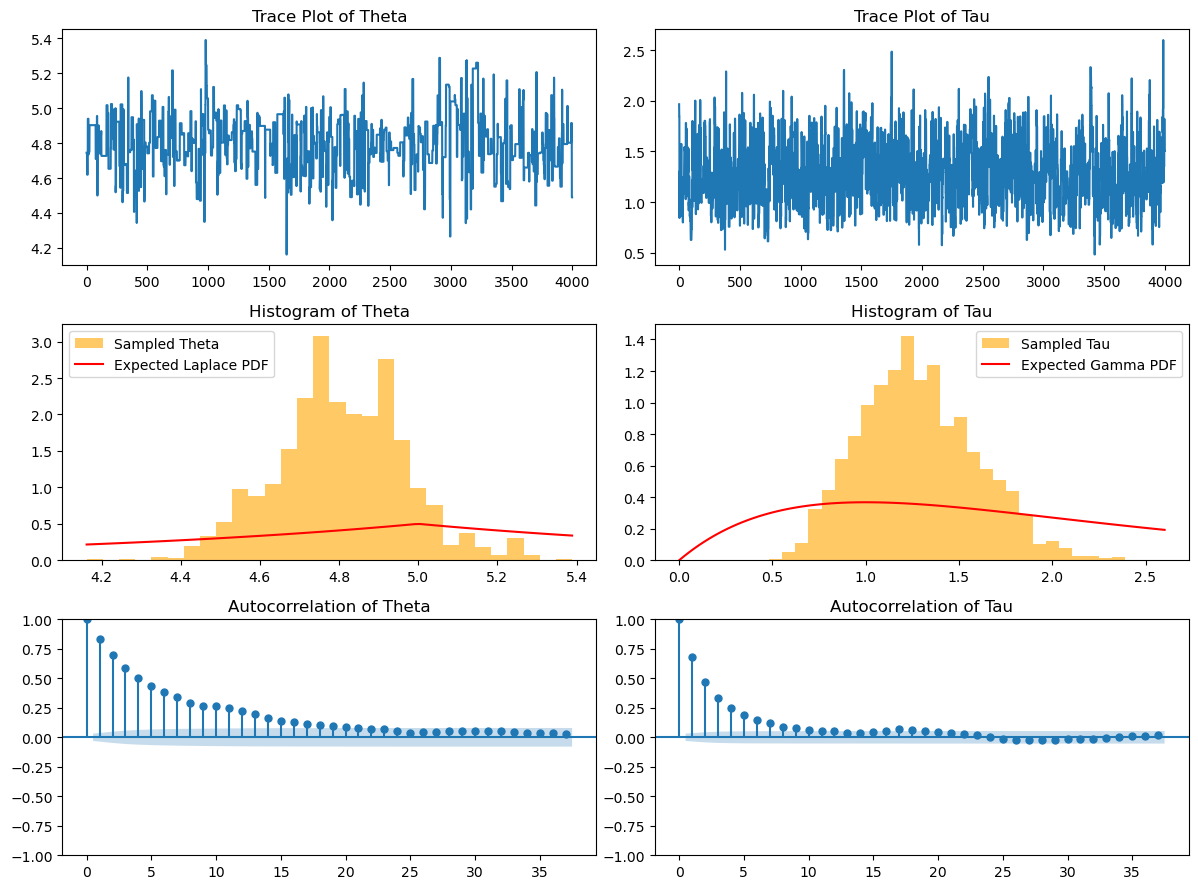

In [17]:
# ---------------------------------------------
# Plot Results
# ---------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

# Trace plots
axes[0, 0].plot(theta_samples)
axes[0, 0].set_title("Trace Plot of Theta")
axes[0, 1].plot(tau_samples)
axes[0, 1].set_title("Trace Plot of Tau")

# Histograms with priors
x_range = np.linspace(min(theta_samples), max(theta_samples), 100)
theta_prior_pdf = stats.laplace.pdf(x_range, loc=true_theta, scale=true_tau)
axes[1, 0].hist(theta_samples, bins=30, density=True, alpha=0.6, color="orange", label="Sampled Theta")
axes[1, 0].plot(x_range, theta_prior_pdf, "r", label="Expected Laplace PDF")
axes[1, 0].set_title("Histogram of Theta")
axes[1, 0].legend()

tau_range = np.linspace(0, max(tau_samples), 100)
tau_prior_pdf = stats.gamma.pdf(tau_range, a=alpha, scale=1/lam)
axes[1, 1].hist(tau_samples, bins=30, density=True, alpha=0.6, color="orange", label="Sampled Tau")
axes[1, 1].plot(tau_range, tau_prior_pdf, "r", label="Expected Gamma PDF")
axes[1, 1].set_title("Histogram of Tau")
axes[1, 1].legend()

# Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(theta_samples, ax=axes[2, 0])
axes[2, 0].set_title("Autocorrelation of Theta")
plot_acf(tau_samples, ax=axes[2, 1])
axes[2, 1].set_title("Autocorrelation of Tau")

plt.tight_layout()
plt.show()

#### Discussion
When using MH within Gibbs Sampler, knowing full conditional distribution is not required since MH allows us to approximate the sample without knowing the full conditional distribution. On the other hand, the process of exploring the distribution is slower in MH for using proposal and rejection. If we know the full conditional distribution, sampling would be direct and more efficient. So, MH is very helpful when it's hard to analyze the full conditional distribution. In this question, issues similar to Q1 have happened again. I have adjusted the proposal distributions but it's not helpful for histogram of Theta/Tau.

## Q3

acceptance probability:

$$
A(x^{(t-1)} \to \tilde{x}^{(t)}) = \min\left(1, \frac{p(\tilde{x}^{(t)}) q(x^{(t-1)} | \tilde{x}^{(t)})}{p(x^{(t-1)}) q(\tilde{x}^{(t)} | x^{(t-1)})} \right)
$$

We need to compute:

$$
A(0 \to 1) = \min\left( 1, \frac{p(1) q(0 | 1)}{p(0) q(1 | 0)} \right)
$$

Substituting the given values:

$$
A(0 \to 1) = \min\left( 1, \frac{\frac{2}{3} \times \frac{1}{2}}{\frac{1}{3} \times \frac{1}{2}} \right) = \min(1, 2) = 1
$$

Similarly, for the reverse move:

$$
A(1 \to 0) = \min\left( 1, \frac{p(0) q(1 | 0)}{p(1) q(0 | 1)} \right)
$$

$$
A(1 \to 0) = \min\left( 1, \frac{\frac{1}{3} \times \frac{1}{2}}{\frac{2}{3} \times \frac{1}{2}} \right) = \min(1, \frac{1}{2}) = \frac{1}{2}
$$

The transition probability matrix \( K \) is:

$$
K_{ij} = q(j | i) A(i \to j) + \delta_{ij} (1 - A(i \to \tilde{i}))
$$

For $x^{t-1} = 0$:

$$
\Pr(x^{t} = 0 \to x^{t+1} = 0) = q(0 | 0) (1 - A(0 \to 1)) + q(1 | 0) A(0 \to 1)
$$

$$
= \frac{1}{2} (1 - 1) + \frac{1}{2} (1) = 0.5
$$

$$
\Pr(x^{t} = 0 \to x^{t+1} = 1) = q(1 | 0) A(0 \to 1) = \frac{1}{2} \times 1 = 0.5
$$

For $x^{t-1} = 1$:

$$
\Pr(x^{t} = 1 \to x^{t+1} = 1) = q(1 | 1) (1 - A(1 \to 0)) + q(0 | 1) A(1 \to 0)
$$

$$
= \frac{1}{2} (1 - \frac{1}{2}) + \frac{1}{2} \times \frac{1}{2} = 0.75
$$

$$
\Pr(x^{t} = 1 \to x^{t+1} = 0) = q(0 | 1) A(1 \to 0) = \frac{1}{2} \times \frac{1}{2} = 0.25
$$

Thus, the transition kernel \( K \) is:

$$
K =
\begin{bmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{bmatrix}
$$

